In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler


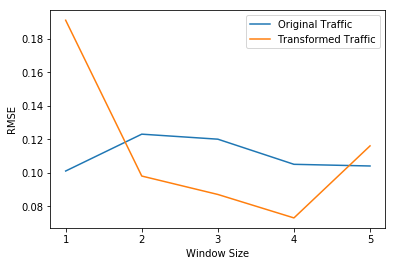

In [21]:
line1 = [0.101, 0.123, 0.120, 0.105, 0.104] #Original Traffic
line2 = [0.191, 0.098, 0.087, 0.073, 0.116] #Transformedraffic
x = np.array(list(range(1, 6)))
plt.plot(x, line1)
plt.plot(x, line2)
plt.xticks(x)
plt.legend(["Original Traffic", "Transformed Traffic"])
plt.xlabel("Window Size")
plt.ylabel("RMSE")

plt.show()

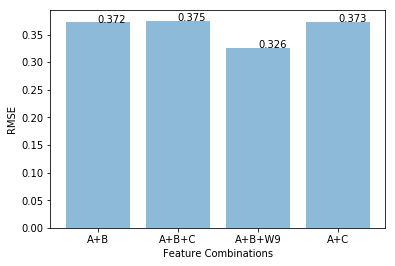

In [33]:
abc = 0.375
ab = 0.372
ac = 0.373
ab9 = 0.326

datasets = ["A+B+C", "A+B", "A+C", "A+B+W9"]
scores = [abc, ab, ac, ab9]

plt.bar(datasets, scores, align='center', alpha=0.5)
for a, b in zip(datasets, scores):
    plt.text(a, b, str(b))
    
plt.xlabel("Feature Combinations")
plt.ylabel("RMSE")
plt.show()

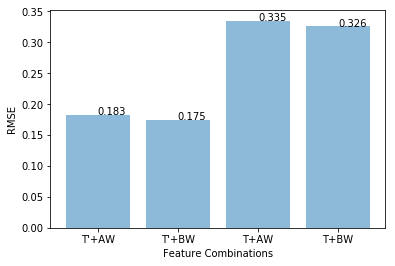

In [41]:
abc = 0.335
ab = 0.183
ac = 0.326
ab9 = 0.175

datasets = ["T+AW", "T'+AW", "T+BW", "T'+BW"]
scores = [abc, ab, ac, ab9]

plt.bar(datasets, scores, align='center', alpha=0.5)
for a, b in zip(datasets, scores):
    plt.text(a, b, str(b))
plt.xlabel("Feature Combinations")
plt.ylabel("RMSE")
plt.show()

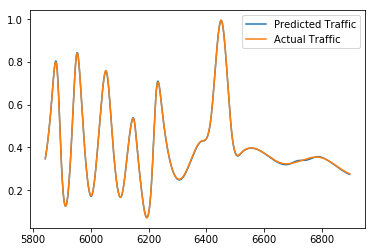

In [65]:
output = pd.read_csv("logs/3-TAFT/fc_output_Taft Ave._2015.csv", skipinitialspace=True)
output.head()

startIndex = 5844
endIndex = 6899

#1 whole month
dt = output.dt[startIndex-2:endIndex-1]
actual = output.Actual[startIndex-2:endIndex-1]
predicted = output.Predicted[startIndex-2:endIndex-1]


plt.plot(predicted)
plt.plot(actual)
plt.legend(["Predicted Traffic", "Actual Traffic"])
plt.show()

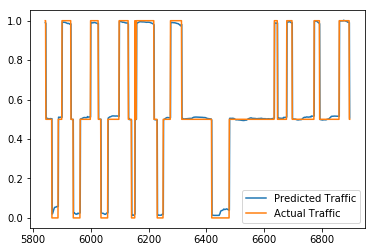

In [67]:
output = pd.read_csv("logs/7-TAFT (Orig Traffic, temp-windspd,temp4,press4)/fc_output_Taft Ave._2015.csv", skipinitialspace=True)
output.head()

startIndex = 5844
endIndex = 6899

#1 whole month
dt = output.dt[startIndex-2:endIndex-1]
actual = output.Actual[startIndex-2:endIndex-1]
predicted = output.Predicted[startIndex-2:endIndex-1]


plt.plot(predicted)
plt.plot(actual)
plt.legend(["Predicted Traffic", "Actual Traffic"])
plt.show()